In [1]:
from toolz.curried import *

import pandas as pd
import numpy as np

import statsmodels.formula.api as smf

import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib
from cycler import cycler

color=['0.0', '0.4', '0.8']
default_cycler = (cycler(color=color))
linestyle=['-', '--', ':', '-.']
marker=['o', 'v', 'd', 'p']

plt.rc('axes', prop_cycle=default_cycler)

#### Geo and Switchback Experiments

How do you design experiments to gather data such as repeated observations over time (panel data) to aid in the process of causal inference. What are the alternative experimental design when simple A/B testing won't work.

Infering the impact of marketing is challenging because you cannot randomize people who are not yet your customers, as in a simple A/B testing,. Online marketing provides attribution tools, but attribution is not the same as incrementality. A promising alternative is to conduct a geo-experiment: treat entire markets, such as a city or a state, while leaving others as control. This approach will provide you with panel data. Its important to know how to best select the treated and control markets in such an experiment. The idea is to zoom out the unit of analysis from customers to cities or states. This comes at a price in terms of sample size since there are far more customers than there are cities. 

In some cases, even randomizing cities may not be possible. A small company operating locally may not have many markets in which to conduct an experiment, since there is a single unit of analysis. Switchback experiments involve turning a treatment on and off multiple times. This approach can work even if you have only a single treatment unit. Say you have a small food delivery marketplace operating within a single city and you want to know what happens if you increase the delivery fee, you can increase and decrease prices multiple times and conduct a series of before-and-after analyses.

In [2]:
# Synthetic Control (with Intercept)
from sklearn.base import BaseEstimator, RegressorMixin 
from sklearn.utils.validation import (check_X_y, check_array, check_is_fitted)
import cvxpy as cp 


class SyntheticControl(BaseEstimator, RegressorMixin):      # our estimator is a regressor

    def __init__(self, fit_intercept=False):                # initialize regression estimator
        self.fit_intercept = fit_intercept

    def fit(self, y_pre_co, y_pre_tr):
        y_pre_co, y_pre_tr = check_X_y(y_pre_co, y_pre_tr)  # check X,y for consistent length; X is 2D and y 1D.

        intercept = np.ones((y_pre_co.shape[0],1))*self.fit_intercept   # intercept column is 1 if fit_intercept
        X = np.concatenate([intercept, y_pre_co], axis=1)   # add intercept column
        w = cp.Variable(X.shape[1])             # weights (optimization variables) length is number of features

        objective = cp.Minimize(cp.sum_squares(X@w - y_pre_tr)) # minimization function
        constraints = [cp.sum(w[1:]) ==1, w[1:] >= 0]           # intercept not included in constraints

        problem = cp.Problem(objective, constraints)        # convex optimization problem

        self.loss_ = problem.solve(eps_abs=1)               # eps_abs=1 is essential for default solver to work
        self.w_ = w.value[1:]                               # add fitted attribute, weights values
        self.intercept_ = w.value[0]                        # add fitted attribute, intercept value

        self.is_fitted_ = True                              # add fitted attribute
        return self                                         # return fitted estimator
    
    def predict(self, y_co):
        check_is_fitted(self)       # verify presence of fitted attributes (ending with a trailing underscore)
        y_co = check_array(y_co)    # Input validation on an array      
        return y_co @ self.w_       # predict using weights

#### Geo-Experiments

The dataset below has city as the unit, date as the time dimension; a treated column, which marks if the city is eventually treated; a post-treatment column, which marks the post-intervention period. There's also auxilliary columns, like population in that city (2013, so fixed in time), and state. The outcome is number of app downloads. The goal is to decide which cities to treat, so we'll discard the post-intervention period. That is, the objective is to select a group of cities that is representative of the total market. That way, if you treat that group, you'll get an idea of what would happen if the entire market (i.e., country) was treated. 

It's always worth trying the simple things. If you have lots of geographical units (i.e. many cities), perhaps a simple A/B testing would work just fine. Simply choose at random a fraction of the cities to compose the treatment group. Only difference is that you would be shifting the unit of analysis from people (potential customers) to entire cities. To know how many cities are enough, you could start with the simple power formula ($n=16\sigma^2/\delta^2$). For the dataset below, that is 40,000 cities needed for a simple A/B testing but you only have 50 cities. So what are your options now?.

When considering different experimental options, it's essential to take into account how you will interpret the results. If you plan on using difference-in-differences method, you can identify pairs of cities that have similar trends in the outcome variable and randomize within each pair. One city would receive the treatment while the other serves as control. Diff-in-diff method estimates the average treatment effect on the treated (ATT). To know the overall effect of the treatment, the ATT estimate may not recover that. We will need to maximize the external validity of the experiment by identifying a treatment group that is representative of the entire market.

In [3]:
df = (pd.read_csv("data/online_mkt.csv")
      .astype({"date": "datetime64[ns]"})
      .query("post==0"))   # only pre-intervention periods (post=0) because we are now designing the experiment
df.head()

,app_download,population,city,state,date,post,treated
0,3066.0,12396372,sao_paulo,sao_paulo,2022-03-01,0,1
1,2701.0,12396372,sao_paulo,sao_paulo,2022-03-02,0,1
2,1927.0,12396372,sao_paulo,sao_paulo,2022-03-03,0,1
3,1451.0,12396372,sao_paulo,sao_paulo,2022-03-04,0,1
4,1248.0,12396372,sao_paulo,sao_paulo,2022-03-05,0,1


In [4]:
# power analysis to detect an effect of 5% in the outcome
detectable_diff = df["app_download"].mean()*0.05   # 5% of the expectation of the outcome
sigma_2 = df.groupby("city")["app_download"].mean().var()  # variance of average outcome per unit
np.ceil((16*sigma_2)/(detectable_diff)**2)

36663.0

#### Synthetic Control Design

Synthetic control is about finding a group of units whose time series can best approximate the outcome of interest. As such you can repurpose the method to find a synthetic treatment unit that approximates the average behavior of all units. To do so, you'll need the data in matrix form, where rows are the time periods and columns are the cities (units), $Y_{T,n}$.

Each city contributes differently for the average. To get the global average, you first need to know how much each city contributes to it. This can be represented by a city weight vector $f$ where each entry $i$ represents the size of city $i$ as a share of the total market. Once $f$ is defined, the objective is to find a set of weights w, such that 

$Y_{post}f=Y_{post}w$ 

You want to find a combination of treatment cities that when combined with weights w, will give you the average outcome of the market. The obvious solution would be $f=w$, but that would mean treating every city, leaving no control units to estimate the treatment effect, so you add a constraint, that the number of nonzero elements in w must be smaller than N, the number of cities: $|w|_0<N\; (|.|_0\;\;the\;L0\;norm\;is\;the\;number\;of\;nonzero\;elements)$. 

If the preceding objective finds the cities that you can use as treatment, the second objective is to find another group of cities, different from the first, that will also approximate the market average:

$Y_{post}f=Y_{post}v\;s.t\;w_iv_i=0\;∀;i$

Combining both objectives, the nonzero elements in $w$ and $v$ become the treatment and control units (cities) respectively. The second objective ensure that you can't use the same city as a treatment and control. Both objectives look at the post-treatment period, meaning they are currently not feasible.

In [5]:
df_piv = (df
          .pivot(index="date", columns="city", values="app_download"))
df_piv.head()

city,ananindeua,aparecida_de_goiania,aracaju,belem,belford_roxo,belo_horizonte,brasilia,campinas,campo_grande,campos_dos_goytacazes,...,sao_bernardo_do_campo,sao_goncalo,sao_jose_dos_campos,sao_luis,sao_paulo,serra,sorocaba,teresina,uberlandia,vila_velha
date,,,,,,,,,,,,,,,,,,,,,
2022-03-01,11.0,54.0,65.0,49.0,52.0,194.0,449.0,326.0,305.0,42.0,...,208.0,148.0,173.0,28.0,3066.0,46.0,207.0,68.0,29.0,63.0
2022-03-02,5.0,20.0,42.0,44.0,25.0,130.0,367.0,172.0,261.0,24.0,...,185.0,157.0,137.0,4.0,2701.0,48.0,98.0,17.0,29.0,11.0
2022-03-03,2.0,0.0,0.0,24.0,13.0,112.0,219.0,292.0,171.0,28.0,...,96.0,72.0,171.0,6.0,1927.0,28.0,87.0,55.0,30.0,14.0
2022-03-04,0.0,0.0,11.0,4.0,34.0,56.0,265.0,154.0,175.0,43.0,...,123.0,102.0,0.0,5.0,1451.0,22.0,47.0,49.0,35.0,0.0
2022-03-05,5.0,5.0,0.0,16.0,12.0,45.0,135.0,122.0,189.0,35.0,...,99.0,53.0,112.0,12.0,1248.0,21.0,36.0,31.0,6.0,1.0


In [6]:
# vector of proportion of population in each unit
f = (df.groupby("city")["population"].first()   # population of each city (first non-null population per city)  
    / df.groupby("city")["population"].first().sum())   # total population of all cities; sum first non-null

In [7]:
f.head()

city
ananindeua              0.007889
aparecida_de_goiania    0.008785
aracaju                 0.009818
belem                   0.021990
belford_roxo            0.007521
Name: population, dtype: float64

To make the objectives feasible, the first step is to look at the pre-intervention period. That is, we need to find two disjoint groups of cities such that a weighted average of each approximates the market average. That alone would be enough, but, practically speaking, you want to add some extra constraints. For example, since the goal is to test a marketing campaign before rolling out to entire market, you don't want to choose too many treatment cities. Moreover in many markets, the size of cities tends to follow an exponential distribution, with a small number of cities accounting for almost all of the market. A big treatment group would treat almost everyone and defeat the purpose of the test. Also, if you use the canonical synthetic control formulation, you would be forced to include the biggest cities, as you are not allowed to extrapolate. It doesn't make practical sense to be testing in large cities to later apply in smaller cities, so you probably want to allow for an intercept shift in the synthetic control model. Combining all the extra requirements, both objectives and synthetic control constraints, the new objective is:

$min||Y_{pre}f -Y_{pre}w_{tr} -\alpha_0||^2 + ||Y_{pre}f - Y_{pre}v_{co} -\beta_0||^2 \\ s.t\;\Sigma w_i=1\;and\;\Sigma v_i=1, \\ \;\;\;\;\; w_i,v_i\geq 0\;∀\;i,\\ \;\;\;\;\;w_iv_i=0\;∀\;i,\\ \;\;\;\;\;|w|_0\leq m$

First, we add intercept terms $\alpha_0$ and $\beta_0$, to both synthetic treatment and synthetic control objectives. The first two constraints are traditional synthetic control constraints, which states that weights must sum to 1 and be nonnegative. Next, constraint states that a city cannot be used for both treatment and control. Final constraint is on the maximum number of cities, $m$, you want on the treatment set. Finding the $best$ possible set of treatment and control cities is not strictly necessary, you just need $good\;enough$.


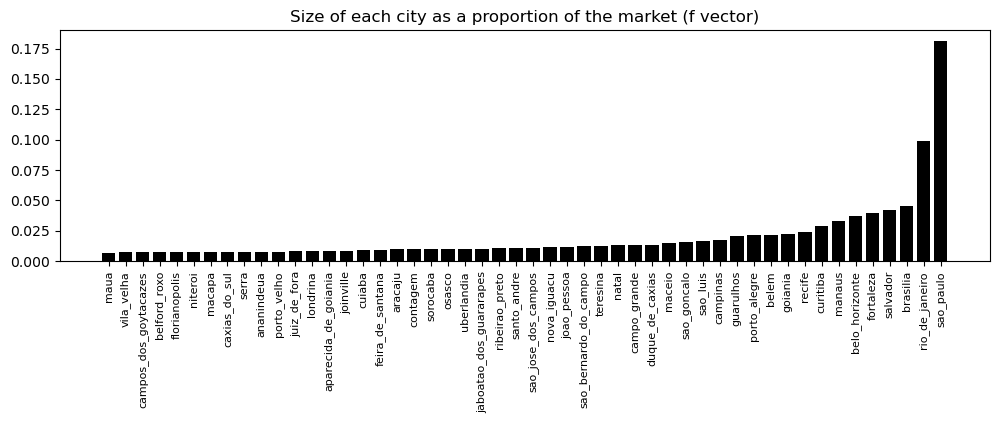

In [8]:
plt.figure(figsize=(12,3))
plt.bar(f.sort_values().index, f.sort_values().values)  # sorted bar chat of city total population proportion 
plt.title("Size of each city as a proportion of the market (f vector)")
plt.xticks(rotation=90, fontsize=8);

#### Trying a Random Set of Treated Units

Before trying to solve the new objective to identify treatment and control cities, we could try a simpler approach involving a random set of cities for treatment. Both treatment and control cities, have to approximate the market average. To get the market average for each date, we dot product each row of the pivoted dataframe with the market share vector f. We set the maximum treatment cities as 5. 

We use synthetic control with intercept drift to find weights for combining cities to approximate the market average for each day. We first randomly choose 5 cities to be used as possible treatment, run synthetic control on these 5 cities, filter out the weights that are close to 0, and store the remaining as the chosen treatment cities. We drop the columns of the chosen treatment cities from the pivoted dataframe, before running synthetic control on the remaining columns to identify the control cities and their weights. We store the chosen synthetic treatment and control cities as well as the sum of synthetic treatment loss and synthetic control loss for minimization.

In the plot below, when plotting both synthetic treatment and control alongside the market average, its clear that the synthetic treatment has a poor fit, the synthetic control matches the average almost exactly.

In [9]:
y_avg = df_piv.dot(f) #  population fraction weighted average of pivot table per date
geos = list(df_piv.columns)         # city names
n_tr = 5                            # maximum number of treatment cities

In [10]:
y_avg.head()  #  population fraction weighted market average per date

date
2022-03-01    767.820880
2022-03-02    652.331457
2022-03-03    484.948194
2022-03-04    348.207275
2022-03-05    288.963059
dtype: float64

In [11]:
np.random.seed(1)
rand_geos = np.random.choice(geos, n_tr, replace=False) # randomly select 5 random cities
rand_geos

array(['manaus', 'recife', 'sao_bernardo_do_campo', 'salvador', 'aracaju'],
      dtype='<U23')

In [12]:
# weights for combining selected cities to model market average
def get_sc(geos, df_sc, y_mean_pre):
    model = SyntheticControl(fit_intercept=True)            # initialize synthetic control model with intercept
    model.fit(df_sc[geos], y_mean_pre)      # find weights for selected cities to predict average market average

    selected_geos = geos[np.abs(model.w_) > 1e-5]  # use cities whose absolute weights are not too close to 0
    return {"geos": selected_geos, "loss": model.loss_}     # selected cities, model loss for optimization

get_sc(rand_geos, df_piv, y_avg)

{'geos': array(['salvador', 'aracaju'], dtype='<U23'),
 'loss': 1598616.80875266}

In [13]:
def get_sc_st_combination(treatment_geos, df_sc, y_mean_pre):
    treatment_result = get_sc(treatment_geos, df_sc, y_mean_pre)    # sc for non-zero weights for treatment

    remaining_geos = df_sc.drop(
        columns=treatment_result["geos"]   # treatment cities are stored in geos key of result
        ).columns  # remaining columns for control after dropping columns chosen for treatment

    control_result = get_sc(remaining_geos, df_sc, y_mean_pre)      # sc for non-zero weights for control

    return {"st_geos": treatment_result["geos"],                        # treatment cities
            "sc_geos": control_result["geos"],                          # control cities
            "loss": treatment_result["loss"] + control_result["loss"]   # total loss of current choices 
            }
resulting_geos = get_sc_st_combination(rand_geos, df_piv, y_avg)

In [14]:
resulting_geos.get("st_geos")

array(['salvador', 'aracaju'], dtype='<U23')

In [15]:
resulting_geos.get("sc_geos")

Index(['ananindeua', 'aparecida_de_goiania', 'belem', 'belford_roxo',
       'belo_horizonte', 'brasilia', 'campinas', 'campo_grande',
       'campos_dos_goytacazes', 'caxias_do_sul', 'contagem', 'cuiaba',
       'curitiba', 'duque_de_caxias', 'feira_de_santana', 'florianopolis',
       'fortaleza', 'goiania', 'guarulhos', 'jaboatao_dos_guararapes',
       'joao_pessoa', 'joinville', 'juiz_de_fora', 'londrina', 'macapa',
       'maceio', 'manaus', 'maua', 'natal', 'niteroi', 'nova_iguacu', 'osasco',
       'porto_alegre', 'porto_velho', 'recife', 'ribeirao_preto',
       'rio_de_janeiro', 'santo_andre', 'sao_bernardo_do_campo', 'sao_goncalo',
       'sao_jose_dos_campos', 'sao_luis', 'sao_paulo', 'serra', 'sorocaba',
       'teresina', 'uberlandia', 'vila_velha'],
      dtype='object', name='city')

In [16]:
len(resulting_geos.get("st_geos")) + len(resulting_geos.get("sc_geos"))

50

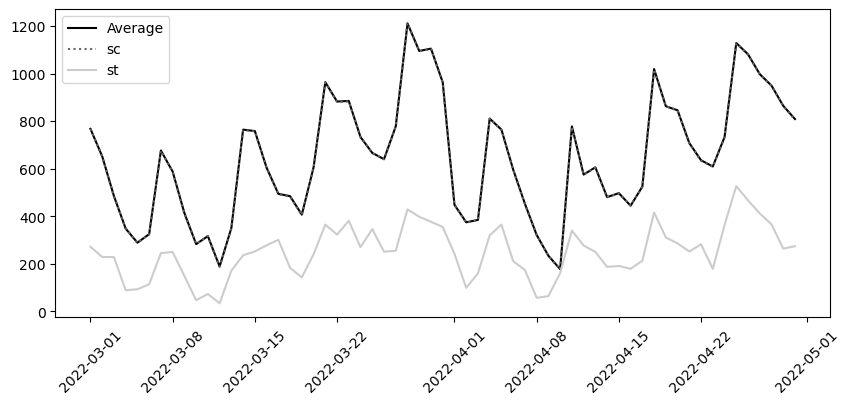

In [17]:
# Comparing the market average predicted by treatment, control city models to actual
synthetic_tr = SyntheticControl(fit_intercept=True)     # sythetic control model to fit to treatment cities
synthetic_co = SyntheticControl(fit_intercept=True)     # synthetic control model to fit to control cities

synthetic_tr.fit(df_piv[resulting_geos.get("st_geos")], y_avg)  # fit market average model to treatment cities
synthetic_co.fit(df_piv[resulting_geos.get("sc_geos")], y_avg)  # fit market average model to control cities

# 
plt.figure(figsize=(10,4))
plt.plot(y_avg, label="Average")  # actual market average per date
plt.plot(y_avg.index, synthetic_co.predict(df_piv[resulting_geos.get("sc_geos")]), label="sc", ls=":") #control
plt.plot(y_avg.index, synthetic_tr.predict(df_piv[resulting_geos.get("st_geos")]), label="st") #treatment
plt.xticks(rotation=45)
plt.legend()

In [18]:
(synthetic_tr.predict(df_piv[resulting_geos.get("st_geos")]) > 600).sum() # treatment prediction falls short

0

#### Random Search 

To reduce the total loss given the number of cities, we can start with randomly searching many combinations and picking one that is okay. In the code below, having set the maximum number of cities to 5, we create a 1000 different groups of 5 cities, and get the synthetic treatment and control cities using the previous steps. We then select the group with the minimum loss, and plot the actual market average against the predictions by the synthetic treatment and control of this group. The results show that we are able to use random search to find a set of synthetic treatment and control cities that are able to adequately predict the market average.

In [19]:
from joblib import Parallel, delayed
from toolz import partial

np.random.seed(1)
geo_samples = [np.random.choice(geos, n_tr, replace=False) 
               for _ in range(1000)]  # 1000 different sets of n_tr treatment cities

est_combination = partial(get_sc_st_combination,
                          df_sc=df_piv,
                          y_mean_pre=y_avg) # initialize partially defined function (treatment_geos not given)

results = Parallel(n_jobs=-1)(delayed(est_combination)(geos) # feed each random treatment city choice
                             for geos in geo_samples) # into partially defined function delayed and parallel

/opt/anaconda3/lib/python3.8/site-packages/cvxpy/problems/problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/cvxpy/problems/problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/cvxpy/problems/problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/cvxpy/problems/problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


In [20]:
resulting_geos = min(results, key=lambda x: x.get("loss")) # sort dictionaries in ascending order of loss key
resulting_geos.get("st_geos")  # treatment set of random search result with the lowest loss 

array(['goiania', 'sao_paulo', 'joao_pessoa', 'manaus', 'niteroi'],
      dtype='<U23')

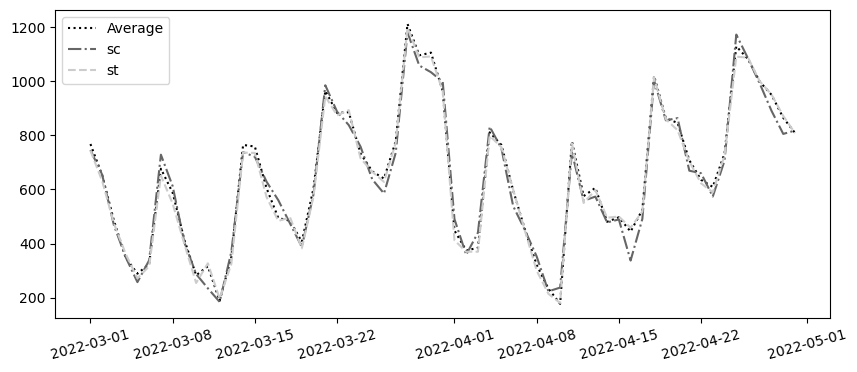

In [21]:
# Comparing the market average predicted by treatment, control city models to actual
synthetic_tr = SyntheticControl(fit_intercept=True)     # sythetic control model to fit to treatment cities
synthetic_co = SyntheticControl(fit_intercept=True)     # synthetic control model to fit to control cities

synthetic_tr.fit(df_piv[resulting_geos.get("st_geos")], y_avg)  # market average model for treatment cities
synthetic_co.fit(df_piv[resulting_geos.get("sc_geos")], y_avg)  # market average model for control cities

# 
plt.figure(figsize=(10,4))
plt.plot(y_avg, label="Average", ls=":")
plt.plot(y_avg.index, synthetic_co.predict(df_piv[resulting_geos.get("sc_geos")]), label="sc", ls="-.")
plt.plot(y_avg.index, synthetic_tr.predict(df_piv[resulting_geos.get("st_geos")]), label="st", ls="--")
plt.xticks(rotation=15)
plt.legend()

In [22]:
resulting_geos.get("loss")  # minimum loss after random search

87108.49604104998

#### Switchback Experiment

Synthetic control experiment designs are great for when you have a small number of units and you want to select the best of them to compose a treatment group. You still need a reasonable amount of units. If you have a small number of units say four units or even one unit, you need an alternative experiment design. For example, a small food delivery marketplace that operates within a single city, that uses dynamic pricing to regulate the supply and demand of the food delivery marketplace, and wants to to know how an increase in delivery fee can impact delivery time by attracting more drivers while throttling or postponing customer demand. Traditional A/B testing wouldn't work here because increasing the price for 50% of customers would also benefit those in the control group (no independence), since overall demand would fall, increasing the number of available drivers. This means the delivery time recorded is not only due to drivers being attracted to the marketplace because of the higher prices, but also due to drivers sitting around waiting for an order because demand fell. Also, synthetic control experiments wouldn't work either, because company operates in just one city. 

If the effect of rising prices dissipate quickly once they go back to normal level, the company can turn the price increases on and off multiple times and do a sequence of before-and-after comparisons. This approach, called switchback experiments, is great for when you have just one or a very small number of units. For this to work, the order of the carryover effect must be small. That is, the effect of the treatment cannot propagate to many periods after the treatment. In the food delivery case, increasing prices tend to cause an increase in supply of drivers shortly after; when prices are back to normal, the excess supply dissipates in a few hours. Hence, the order of the carryover is small, so switchback experiments are an interesting proposition.

In [23]:
df = pd.read_csv("data/sb_exp_every.csv")
df.head()

,d,delivery_time,delivery_time_1,delivery_time_0,tau
0,1,2.84,2.84,5.84,-3.0
1,0,4.49,1.49,6.49,-5.0
2,0,7.27,2.27,8.27,-6.0
3,1,5.27,2.27,8.27,-6.0
4,1,5.59,4.59,10.59,-6.0


We have data for a switchback experiment for 120 time periods. The column $d$ is a boolean that indicates if the treatment (delivery price increases) is on or off. The $delivery\_time$ is the outcome of interest; if treatment is on, we expect more drivers for direct pickup and therefore shorter delivery times otherwise shared pickups and longer delivery times. Because data is simulated, we have two counterfactual columns $delivery\_time\_0$ and $delivery\_time\_1$, which are what the delivery times for the hour would be if treatment was on or off respectively. The difference between $delivery_time_0$ and $delivery_time_1$ is the causal effect of the treatment $\tau$, given in column $tau$. Since treatment decreases the delivery time, the effect is negative. Also due to carryover, the effects on the first two periods is smaller. 

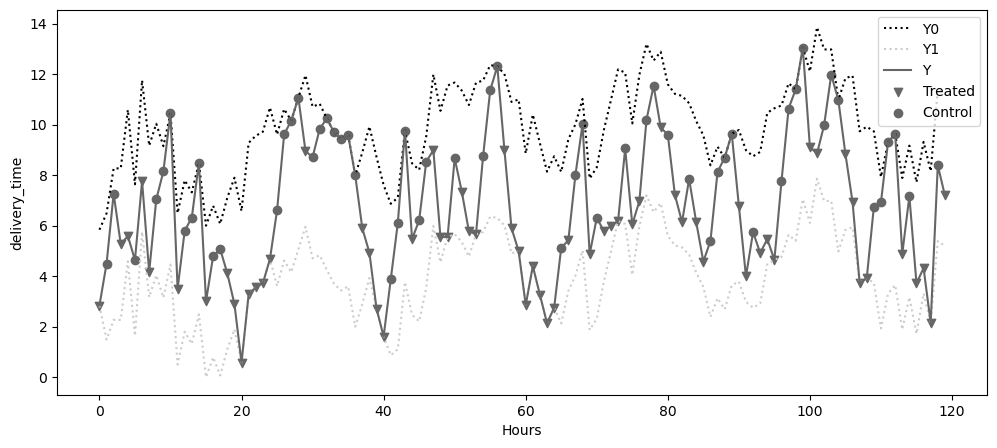

In [24]:
plt.figure(figsize=(12,5))
x = df.index 
plt.plot(x, df["delivery_time_0"], ls=":", color="0.0", label="Y0")     # control counterfactual 
plt.plot(x, df["delivery_time_1"], ls=":", color="0.8", label="Y1")     # treatment counterfactual
plt.plot(x, df["delivery_time"], color="0.4", label="Y")                # actual outcome
plt.scatter(x[df["d"]==1], df["delivery_time"][df["d"]==1], label="Treated", marker="v", color="0.4") # treated 
plt.scatter(x[df["d"]==0], df["delivery_time"][df["d"]==0], label="Control", marker="o", color="0.4") # control 
plt.ylabel("delivery_time")
plt.xlabel("Hours")
plt.legend()

The plot shows that the observed delivery time fluctuates betweent the delivery time you would have with treatment always on and always off. After three consecutive equal treatments, the observed outcome matches the one you would have with treatment always on or always off. At T=20 to T=23, due to chance, the treatment was on for three or more consecutive periods and the delivery time matches the delivery time you would have under the treatment being always on. Conversely, around T=32, a sequence where the treatment has been off (control) leads to the observed outcome matching the delivery time you would have if the treatment was always off. If the treatment was on or off for less than three consecutive periods, the observed outcome is somewhere in the middle. The outcome depends on the treatment of three periods: the immediate treatment and treatment from two periods before, ie the order of the carryover effect is 2. In reality, you wouldn't know the order of the carryover effect because you only see the observed outcome.

$Y_t=f(d_{t-2}, d_{t-1}, d_t)$

In [25]:
df.d.mean() # we randomize treatment in the time dimension

0.5166666666666667

In [26]:
df.iloc[19:27,:] # order of carryover effect

,d,delivery_time,delivery_time_1,delivery_time_0,tau
19,1,2.90,1.90,7.90,-6.0
20,1,0.58,0.58,6.58,-6.0
21,1,3.28,3.28,9.28,-6.0
22,1,3.56,3.56,9.56,-6.0
23,1,3.72,3.72,9.72,-6.0
24,1,4.68,4.68,10.68,-6.0
25,0,6.61,3.61,9.61,-6.0
26,0,9.62,4.62,10.62,-6.0


In [27]:
df.iloc[29:40,:] # order of carryover effect is 2

,d,delivery_time,delivery_time_1,delivery_time_0,tau
29,1,8.96,5.96,11.96,-6.0
30,0,8.71,4.71,10.71,-6.0
31,0,9.83,4.83,10.83,-6.0
32,0,10.25,4.25,10.25,-6.0
33,0,9.71,3.71,9.71,-6.0
34,0,9.43,3.43,9.43,-6.0
35,0,9.60,3.60,9.60,-6.0
36,0,8.00,2.00,8.00,-6.0
37,1,5.90,2.90,8.90,-6.0
38,1,4.93,3.93,9.93,-6.0


#### Potential Outcome of Sequences

Since the effect of treatment carries over to subsequent time, when it comes to switchback experiments, the potential outcome has to be defined in terms of a vector of treatments, $Y_t(D)=Y_t([d_0,d_1,d_2,...,d_T])$. First, assuming no anticipation of the treatment, the potential outcome will only depend on current and past treatment, but not on future ones, so we need not consider all T periods ie $Y_t(D)=Y_t([d_0,d_1,d_2,...,d_t])$. Second, assuming you know the size of the carryover period $m$, you could write it as $Y_t(D)=Y_t([d_{t-m},d_{t-(m-1)},..., d_t])$. In the example dataset, $m=2$, the potential outcome simplifies to $Y_t(D)=Y_t([d_{t-2},d_{t-1},d_t])$, a lot simpler than you would have with no assumptions at all. Having the potential outcome vectors, we can write the total effect of the treatment as the effect of going from an always off treatment to an always on treatment (vector).

$\tau_m = E[Y_t(1_{t-m},...,1_t) - Y_t(0_{t-m}, ..., 0_t)]$ 

This is the effect of going from an always off treatment to an always on treatment. In the case where $m=2$, this would be $E[Y_t(1,1,1) - Y_t(0,0,0)]$, which of course requires you know $m$, the carryover period.

#### Estimating the Order of Carryover Effect

Say you know an upper bound on m. For instance, you know that the effect of price increases doesn't last for more than 6 hours. In that case, you can regression-estimate the model (using the previous 6 timestamps), and read the parameter estimate's size and significance. 

$y_t = \alpha + d_t + d_{t-1}, ... , d_{t-K} + e_t$

The order of the carryover effect will depend on which parameters are statistically significant and also have a large impact on the outcome. This also imposes another assumpiton, which is that the effects of the lags are additive. 

$Y_t = f(d_t, d_{t-1}, d_{t-2}) = \alpha + d_t + d_{t-1}, d_{t-2} + e_t$

Once you have the data with its lags, all you have to do is regress the outcome on the lags and the current treatment (which can be thought of as lag 0). Using pandas shift() and assign methods we can add the lagged data in preparation for regression. The shift() method will introdue NaN values for undefined lags. Using statsmodels for the regression is convenient here, because it will drop the rows with NaNs.

In [28]:
df_lags = df.assign(**{                             # using assign(), shift and **operator to add lag columns
    f"d_l{l}" : df["d"].shift(l) for l in range(7) # each col d_l_x, the result of shifting df['d'] by x periods
})
df_lags[[f"d_l{l}" for l in range(7)]].head() #

,d_l0,d_l1,d_l2,d_l3,d_l4,d_l5,d_l6
0,1,NaN,NaN,NaN,NaN,NaN,NaN
1,0,1.0,NaN,NaN,NaN,NaN,NaN
2,0,0.0,1.0,NaN,NaN,NaN,NaN
3,1,0.0,0.0,1.0,NaN,NaN,NaN
4,1,1.0,0.0,0.0,1.0,NaN,NaN


In [29]:
# Regressing outcome against lags to identify carryover
import statsmodels.formula.api as smf 

model = smf.ols("delivery_time ~" + "+".join([f"d_l{l}" for l in range(7)]), # formula
                data=df_lags).fit()
model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,9.3270,0.461,20.246,0.000,8.414,10.240
d_l0,-2.9645,0.335,-8.843,0.000,-3.629,-2.300
d_l1,-1.8861,0.339,-5.560,0.000,-2.559,-1.213
d_l2,-1.0013,0.340,-2.943,0.004,-1.676,-0.327
d_l3,0.2594,0.341,0.762,0.448,-0.416,0.935
d_l4,0.1431,0.340,0.421,0.675,-0.531,0.817
d_l5,0.1388,0.340,0.408,0.684,-0.536,0.813
d_l6,0.5588,0.336,1.662,0.099,-0.108,1.225


Looking at the lag parameters, they are significant up to lag 2 ((P>|t|) less than 0.05) which indicates a carryover effect of 2. How do we use said information to determine the estimate for the total effect, $\tau_m$, and the confidence interval of said estimate. With a regression model, you don't need to know the correct order of the carryover effect $m$ to estimate the total effect $\tau_m$, as long as your regression contains more lags than the correct $m$ you can just sum up all the lag parameter estimates. To get the variance, you also have to sum up the variance of each individual lag. When using a bunch of unneeded lags, the total effect estimate will be imprecise, but if you settle for exactly the needed carryover lags, you can reduce the variance substantially.

$\hat \tau_m=\Sigma_{l=0}^{lags}\hat d_{t-l}$

In [30]:
# Estimating treatment effect using more than needed lags
tau_m_hat = model.params[1:].sum()                  # parameter estimates, remember to remove the intercept
se_tau_m_hat = np.sqrt((model.bse[1:]**2).sum())    # standard error, remember to remove the intercept
print("tau_m:", tau_m_hat)
print("95% CI:", [tau_m_hat - 1.96*se_tau_m_hat,
                  tau_m_hat + 1.96*se_tau_m_hat])   # 95% CI

tau_m: -4.751686115272031
95% CI: [-6.508718378154567, -2.9946538523894954]


In [31]:
# Regressing the outcome against only the carryover lags ie lag 0 (current), 1, 2
tau_m_hat = model.params[1:4].sum()                 # parameter estimates, remove intercept and lags after lag 2
se_tau_m_hat = np.sqrt((model.bse[1:4]**2).sum())
print("tau_m:", tau_m_hat)
print("95% CI:", [tau_m_hat - 1.96*se_tau_m_hat,
                  tau_m_hat + 1.96*se_tau_m_hat]) 

tau_m: -5.851856895442294
95% CI: [-7.000105171362165, -4.703608619522424]


#### Design-Based Estimation

The previous procedure depends on a correct specification of the model for the potential outcome $Y_t(D)$, which for time series, is not a trivial task. One alternative is to estimate $\tau_m$ with something like inverse propensity weighting (IPW), which would only require knowledge of how the treatment was assigned, which is controlled by the designer of the experiment. This approach only requires you to know the carryover effect order, m.

IPW reconstructs a potential outcome by scaling up the observed outcome by inverse treatment probability $E[\hat Y_d]=N^{-1}\Sigma(Y_d １(D=d)/P(D=d)$, taking into account that potential outcome is defined in terms of a vector of treatment. In the instance that the effect carries over for two periods, m=2, you want to reconstruct $Y_t(0,0,0)$ and $Y_t(1,1,1)$, which requries calculating a running probability of observing three equal treatments in a row. For $m=2$, that would be $P(d_{t-2}=d, d_{t-1}=d, d_t=d)$ or more generally $P(D_{t-m:t}=d)$ where $D_{t-m:t}$ is the vector of the current and last $m$ treatments and $d$ is a vector of constant treatment. This depends on the randomization probability $p$. Assuming $p=50\%$, it means at each randomization point, the treatment has a 50% chance of staying the same or switching. In terms of experiment design, this increases the power of the experiment as it increases the treatment variance. In terms of estimation procedure, it makes so that $P(D_{t-m:t}=1)=P(D_{t-m:t}=0)$. This doesn't mean $P(D_{t-m:t}=d)$ will be the same everywhere; the probability depends on the randomization points and where you are in the sequence. If $p=50\%$, and treatment was randomized at every time period, the running probability of observing three consecutive treatments, like [1,1,1,1,1,1] is [na,na,.5^3,.5^3,.5^3]. However, if you randomize every three periods, the same sequence has a running probability of [na,na, .5, .5^2,.5^2,.5], because at $t=4,5$, the lag 2 window, which contains current time period and previous two, will contain two randomization points.

In [32]:
rad_points_3 = np.array([True, False,False]*(2))    # randomization happens every three periods
rad_points_3                                        # m+1 where m= carryover period, 1 is current time

array([ True, False, False,  True, False, False])

In [38]:
# randomization windows and randomization points
print(rad_points_3*1)
rad_points_3.cumsum() # randomization windows have distinct integers (same integer, same randomization window)

[1 0 0 1 0 0]


array([1, 1, 1, 2, 2, 2])

In [34]:
# create carryover window representing the values affecting current outcome in time
from numpy.lib.stride_tricks import sliding_window_view 

m = 2     # carryover period, m, is # of past vals affecting current; +1 for current gives window size of m+1
sliding_window_view(rad_points_3.cumsum(), window_shape=m+1)    # sliding_window discards windows for first m 

array([[1, 1, 1],
       [1, 1, 2],
       [1, 2, 2],
       [2, 2, 2]])

In [35]:
# number of randomization windows in each carryover window (unique integers in each carryover window)

np.diff(sliding_window_view(rad_points_3.cumsum(), window_shape=m+1), # generate sliding windows of size m+1
                            axis=1) # differencing subsequent entries will indicate if integer changed


array([[0, 0],
       [0, 1],
       [1, 0],
       [0, 0]])

In [40]:
# sum result of np.diff() to yield number of randomization windows in each carryover window
n_rand_windows = np.concatenate([
    [np.nan]*m, # add np.nan for the first m windows discarded by sliding_window_view()
    np.diff(sliding_window_view(rad_points_3.cumsum(),3), 
            axis=1)
            .sum(axis=1)+1 # add 1 to retrieve first window at each point which becomes 0s after difference
])
n_rand_windows  # number of randomization windows in each carryover window 

array([nan, nan,  1.,  2.,  2.,  1.])

In [41]:
# get probability vector by taking probability of experiment 0.5, exponentiate it by preceding array
p = 0.5
p**n_rand_windows

array([ nan,  nan, 0.5 , 0.25, 0.25, 0.5 ])

In [45]:
# Compute P(D_{t-m:t}=d)
def compute_p(rand_points, m, p=0.5):
    n_windows_last_m = np.concatenate([
        [np.nan]*m,
        np.diff(sliding_window_view(rand_points.cumsum(), m+1),
                axis=1).sum(axis=1) + 1
    ])
    return p**n_windows_last_m

We define the randomization interval (boleans), convert to integers, use the cumulative sum to identify the randomization points and windows (all values in the same window will have the same cumulative sum). Then we use the sliding_window_view() to construct carryover windows from the cumulative sum values and window size of m+1 (+1 for the present value, m for the carryover values). This function discards the the first m windows, so we replace them with np.nan since they don't have enough precedent values. To recover the number of randomization points there are in a given carryover window, we pass the result of sliding_window_view() to np.diff() for first-order difference for each carryover window. This operation will identify the randomization points from the carryover windows, since the cumulative sum increases from one randomization interval to another. If all the points in a carryover window are from the same randomization interval, the first-order difference along axis=1, will yield 0's. So to convert the difference to number of randomization points, we sum  along axis=1, and add a 1 to account to the starting window that is lost in first-order difference. With the number of randomization points in each carryover window, we raise the probability of experiment, eg $p=0.5$ and exponentiate it by the array of number of randomization points. 

All of the above is to compute $P(D_{t-m:t}=d)$, you still have to look at the rest of the estimator for the potential outcome:

$\hat Y(d)=\frac{1}{T-m}\Sigma_{t=m+1}^T Y_t \frac{１(D_{t-m:t}=d)}{P(D_{t-m:t}=d)}$

This estimator will scale up the observed outcome by running probability whenever the last treatment and the current one are all the same. Then it will average those scaled-up outcomes. To code this, the only missing piece is the indicator function in the numerator, which evaluates to true whenever the last $m+1$ treatments are equal to d. With the sliding_window_view(), we can create the $m+1$ window view of the treatment array, check if all the elements in that window are equal to the treatment (by checking if each one is equal and checking if each element evaluated to True). The IPW estimator for switchback experiments.

$\tau=\frac{1}{T-m}\Sigma^T_{t=m+1}\{ Y_t(\frac{１(D_{t-m:t}=1)}{P(D_{t-m:t}=1)}-\frac{１(D_{t-m:t}=0)}{P(D_{t-m:t}=0)})\}$

In [53]:
# regular randomization intervals
compute_p(np.ones(6)==1,2,0.5) # rand_points needs start out as boolean hence np.ones(6)==1

array([  nan,   nan, 0.125, 0.125, 0.125, 0.125])

In [46]:
# irregular randomization intervals
rand_points = np.array([True, False, False, True, False, True, False])
compute_p(rand_points, 2, 0.5)

array([ nan,  nan, 0.5 , 0.25, 0.25, 0.25, 0.25])

In [49]:
# indicator function true when last m elements equal d
def last_m_d_equal(d_vec, d, m):
    return np.concatenate([
        [np.nan]*m,
        (sliding_window_view(d_vec, m+1)==d).all(axis=1) # check window elements equal d booleans are all True
    ])

In [50]:
print(last_m_d_equal([1,1,1,0,0,0], 1, m=2))    # identify points for Y(1,1,1)

[nan nan  1.  0.  0.  0.]


In [51]:
print(last_m_d_equal([1,1,1,0,0,0], 0, m=2))    # identify points for Y(0,0,0)

[nan nan  0.  0.  0.  1.]


In [52]:
def ipw_switchback(d, y, rand_points, m, p=0.5):
    p_last_m_equal_1 = compute_p(rand_points, m=m, p=p)     # probability of treatment using p
    p_last_m_equal_0 = compute_p(rand_points, m=m, p=1-p)   # probability of control using 1-p

    last_m_is_1 = last_m_d_equal(d, 1, m)                   # indicator if last m was 1
    last_m_is_0 = last_m_d_equal(d, 0, m)                   # indicator if last m was 0

    y1_rec = y*last_m_is_1/p_last_m_equal_1     # potential outcome if treated by scaling up treated outcomes
    y0_rec = y*last_m_is_0/p_last_m_equal_0     # potential outcome if control by scaling up control outcomes

    # treatment effect, difference in potential outcomes, average of only periods with complete carryovers
    return np.mean((y1_rec - y0_rec)[m:])  

In [54]:
# treatement effect of switchback expriments
ipw_switchback(df["d"],                 # treatment indicator
               df["delivery_time"],     # outcome
               np.ones(len(df))==1,     # randomization points, (treatment randomized each period)
               m=2, p=0.5)              # carryover , probability of treatment

-7.426440677966101

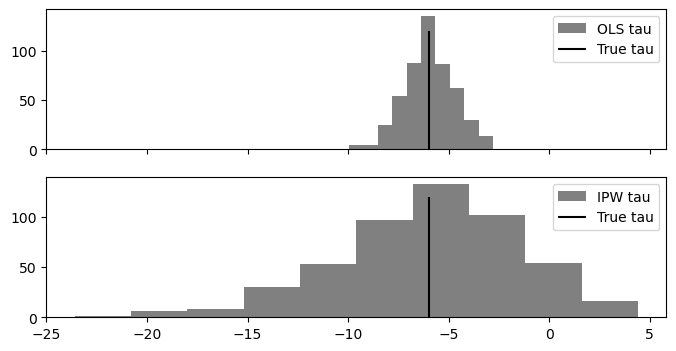

In [64]:
from matplotlib import pyplot as plt 
from statsmodels.tsa.arima_process import ArmaProcess 

def gen_d(rand_points, p):
    result = [np.random.binomial(1,p)]

    for t in rand_points[1:]:
        result.append(np.random.binomial(1,p)*t + (1-t)*result[-1])
    return np.array(result)

def y_given_d(d, effect_params, T, seed=None):
    np.random.seed(seed) if not seed is None else None
    x = np.arange(1, T+1)
    return (np.log(x+1)
            + 2*np.sin(x*2*np.pi/24)
            + np.convolve(~d.astype(bool), effect_params)[:-(len(effect_params)-1)]
            + ArmaProcess([3,2,1], 12).generate_sample(T)).round(2)

def gen_data_rand_every():
    effect_params = [3,2,1]             # ArmaProcess for time series
    T=120                               # total period
    p=0.5                               # probability of treatment
    m=2                                 # carryover period

    d = np.random.binomial(1, 0.5, T)   # number of sample, probability of success, size; treated indicator
    y = y_given_d(d, [3,2,1], T)        # outcome   
    rand_points = np.ones(T)==1         # treatment randomization every period

    return pd.DataFrame(dict(d=d, y=y, rand_points=rand_points)) # treated, outcome, randomized

def tau_ols(df):
    df_lags = df.assign(**{
        f"d_l{l}" : df["d"].shift(l) for l in range(3) # add carryover and current treated dummies 
    })
    model = smf.ols("y ~" + "+".join([f"d_l{l}" for l in range(3)]), 
                    data=df_lags).fit()     # regress outcome over carryover and treated dummies
    return model.params[1:].sum()           # sum up all except intercept for treatment effect

def tau_ipw(df):
    return ipw_switchback(df["d"],
                          df["y"],
                          df["rand_points"], # a column indicating if treatment was randomized at point in time
                          m=2, p=0.5)

np.random.seed(123)
exps_dfs =[gen_data_rand_every() for _ in range(500)]               # generate 500 differnt sample dataframe

fig, (ax1, ax2) = plt.subplots(2,1, sharex=True, figsize=(8,4))
ols_taus = list(map(tau_ols, exps_dfs))         # fit ols to obtain treatment effect values for each dataframe
ax1.hist(ols_taus, label="OLS tau", color="0.5")    # histogram of treatment effect values
ax1.vlines(-6, 0, 120, color="0", label="True tau") # true tau of 0
ax1.legend()

ipw_taus = list(map(tau_ipw, exps_dfs))         # fit ipw to obtain treatment effect values for each dataframe
ax2.hist(ipw_taus, label="IPW tau", color="0.5")    # histogram of treatment effect values
ax2.vlines(-6, 0, 120, color="0",label="True tau")  # true tau of 0
ax2.legend()

#### Optimal Switchback Design

From any estimator, more variance is undesirable. So if designing a switchback experiment, you want to look at the worst possible case and make the least amount of assumptions possible. It is thus attractive to take the IPW estimator and come up with an experiment design, that reduces its variance. 

The IPW estimator only keeps the sequences with $m+1$ consecutive equal treatments. This means it throws away any $m+1$ sequence that has more than one treatment assignment. Looking back at the plot of observed and potential outcomes, it would mean throwing alway all data in between the upper and lower potential outcomes. So, if you want to use more data, make sure you have more consecutive equal treatments by setting all the treatment sequences to either 0 or 1. This would maximize usable data, but decrease the variance of the treatment, a situation, that makes estimation impossible (because we only have treatment or only control). The variance of the estimator can thus be decreased by having both more useful data and higher treatment variance. You have to find a balance.

Intuitively, one way to have more useful data and more treatment variance is by randomizing every $m+1$ period. If the order of the carryover effect is 2, you would randomize every three periods. You can slightly improve if you instead randomize every m periods and add a gap of size m at the beginning and end of the experiment horizon, when m>0.

$T^* = {1,2m+1, 3m+1,...,(n-2)m+1}$

$T^*$ are the optimal randomization points, $m$ is the order of the carryover effect and $n$ is an integer >=4 such that $T/m=n$. The length of the experiment has to be divisible by the carryover order and long enough to contain at least four blocks of size $m$. When there is no carryover $(m=0)$, the optimal design is just randomizing at every period, (ie $T^*$={1,1,...,1} to randomize every period) which would maximize treatment variance while keeping all the data.

In [ ]:
# optimal randomization points when m=2, (0(m)+1, 1(m+1), 2(2)+1, 3(2)+1, 4(2)+1, 5(2)+1)
1, 5, 7, 9, 11, 13,15, 8*2 + 1 = 17             # [1,0,0,0,1,0,1,0,0,0]

In [67]:
m = 2       # carry over effect
T =12       # time periods in experiment
n = T/m     # n is used for the end of the randomization period

np.isin(    # hashset timestamp element-wise membership checking, in optimal randomization times
    np.arange(1, T+1),                                    # timestamps, total periods  
                [1] + [i*m+1 for i in range(2, int(n)-1)] # optimal randomization points (range ends at n-2)
)*1

array([1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0])

In [81]:
np.arange(1, 12+1)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

In [80]:
np.isin([1,2,3,4,5,6,7,8,9,10,11,12], [1, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25])*1 # randomization pts arr

array([1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0])

In [78]:
[1] + [i*m+1 for i in range(2, 13)] # lol supposed to end at n-2 (10) so range should go to n-1 (11) not 13

[1, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25]

In [83]:
np.isin(
    np.arange(1, T+1),
    [1] + [i*m+1 for i in range(2, int(n)-1)]
)

array([ True, False, False, False,  True, False,  True, False,  True,
       False, False, False])

In [86]:
m = 3
T = 15
n = T/m
np.isin(
    np.arange(1, T+1),
    [1] + [i*m+1 for i in range(2, int(n)-1)] # check if current timestamp is in optimal randomization times
)*1

array([1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0])

In [87]:
np.arange(1, T+1)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])

In [88]:
[1] + [i*m+1 for i in range(2, int(n)-1)]

[1, 7, 10]

In [89]:
6+1=7, 9+1=10, 12+1=14

14

In [94]:
def gen_d(rand_points,p):
    result = [np.random.binomial(1,p)]

    for t in rand_points[1:]:
        result.append(np.random.binomial(1,p)*t + (1-t)*result[-1])
    return np.array(result)

T = 120
m = 2 

def gen_exp(rand_points, T):
    effect_params = [3,2,1]
    p = 0.5

    d = gen_d(rand_points, p=p)
    y = y_given_d(d, [3,2,1], T)

    return pd.DataFrame(dict(d=d, y=y, rand_points=rand_points))

every_1 = np.array([True]*T)
every_3 = np.array([True, False, False]*(T//3))
n = T/m                                        # randomization sets 
opt = np.isin(
    np.arange(1, T+1),
    [1] + [i*m+1 for i in range(2, int(n)-1)]  # optimal randomization schedule, m+1 with gaps at start/end
)

np.random.seed(123)
exps_every_1 = [gen_exp(every_1, T) for _ in range(1000)]
exps_every_3 = [gen_exp(every_3, T) for _ in range(1000)]
exps_opt = [gen_exp(opt, T) for _ in range(1000)]

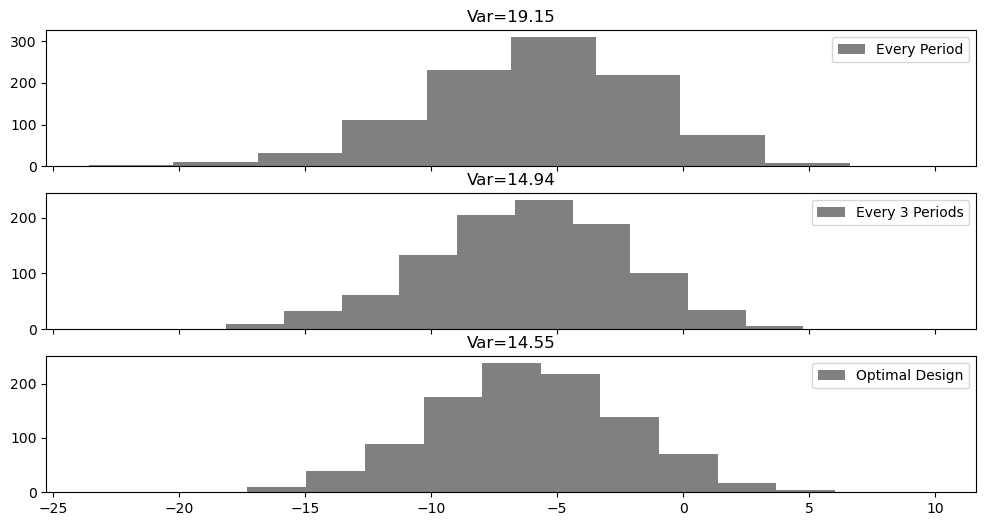

In [99]:
# comparison of treatment variance with different randomization intervals
fig, axs = plt.subplots(3, 1, sharex=True, figsize=(12,6))
ax1, ax2, ax3 = axs.ravel()

taus_every_1_ipw = list(map(tau_ipw, exps_every_1))
ax1.hist(taus_every_1_ipw, label="Every Period", color="0.5")
ax1.set_title(f"Var={np.round(np.var(taus_every_1_ipw),2)}")
ax1.legend()

taus_every_3_ipw = list(map(tau_ipw, exps_every_3))
ax2.hist(taus_every_3_ipw, label="Every 3 Periods", color="0.5")
ax2.set_title(f"Var={np.round(np.var(taus_every_3_ipw),2)}")
ax2.legend()

taus_opt_ipw = list(map(tau_ipw, exps_opt))
ax3.hist(taus_opt_ipw, label="Optimal Design", color="0.5")
ax3.set_title(f"Var={np.round(np.var(taus_opt_ipw),2)}")
ax3.legend()

#### Robust Variance

How you estimate the variance of the IPW estimator, depends on the design of your experiment. In the data below, the food delivery company ran a second experiment, with T=120, p=0.5 but now randomization points are based on the optimal design. To get the variance formula, first partition the data into $K=T/m$ blocks such that each block has size m. Then define the sum of the outcomes of a block k as $\bar Y_k=\Sigma Y_{km+1:(k+1)m^.}$. For instance, if $Y=[1,1,1,2,2,3]$ for $m=2,k=\{1,2\}$, $\bar Y = [\Sigma Y_{3:4}, \Sigma_{5:6}]=[3,5]$, thus throwing away the first block. Having summed up the blocks, a conservative estimate to the variance is:

$\hat \sigma (\hat \tau)=\frac{1}{(T-m)^2}\{8\bar Y_1^2 + \Sigma _{k=2}^{K-1}\; 32 \bar Y^2_k １(d_{km+1} = d_{(k+1)m+1}) + 8 \bar Y _K ^2 \}$

First, the denominator is the square of the sample size. Since you discarded the first $m$ entries, you have to subtract $m$. The numerator is composed of three main terms. The first and last term take into account the gap left at the beginning and end of the optimal design. The middle term has the indicator function that evaluates to 1, whenever two consecutive blocks have the same treatment. Because of the gap at the beginning and end, this is sure to happen for the first and last term, so you don't need the indicator function there. To code this formula, you'll first need to make sure that T is divisible by $m$ by a factor greater or equal to 4. Then, use the hsplit() and vstack() functions to partition the array into blocks and pile up the blocks vertically respectively. Then we sum the columns of the piled-up array to get $\bar Y$. For the indicator function, we do the same thing, but with the treatment vector. Due to the nature of the experiment design, the entire block of treatment will be 1 or 0, so just take the first column to know which treatment was assigned to that block. To know if two consecutive blocks have the same treatment, use the np.diff() function. This will discard yet another block.

The variance obtained with this method, maybe yield a wider confidence interval than OLS and design that randomized every period, but that may be a small price to pay, to avoid making further model assumptions. Even if you follow the optimized design, you can still analyze it with OLS. Even though the optimal design is not meant to minimize the OLS variance, it often gives more precise estimates than randomizing at every period.

In [100]:
df_opt = pd.read_csv("data/sb_exp_opt.csv")
df_opt.head(6)

,rand_points,d,delivery_time
0,True,0,5.84
1,False,0,5.40
2,False,0,8.86
3,False,0,8.79
4,True,0,10.93
5,False,0,7.02


In [135]:
tau_hat = ipw_switchback(df_opt["d"],
                         df_opt["delivery_time"],
                         df_opt["rand_points"],
                         m=2, p=0.5)
tau_hat

-9.921016949152545

In [136]:
np.vstack(np.hsplit(np.array([1,1,1,2,2,3]),3)) # horizontally split into 3 columns then stack vertically

array([[1, 1],
       [1, 2],
       [2, 3]])

In [137]:
# check that two consecutive blocks have the same treatment
np.diff(np.vstack(np.hsplit(np.array([1,1,0,0,0,0]),3))[:,0]) ==0

array([False,  True])

In [143]:
# entire variance function
def var_opt_design(d_opt, y_opt, T, m):
    assert ((T//m == T/m) 
            & (T/m >= 4)),  "T must be divisible by m and T/m >=4" # print message if assert fails

    # discard 1st block
    y_m_blocks = np.vstack(np.hsplit(y_opt, int(T/m))).sum(axis=1)[1:]

    # take 1st column
    d_m_blocks = np.vstack(np.split(d_opt, int(T/m))[1:])[:,0]

    return (
        8*y_m_blocks[0]**2
        + (32*y_m_blocks[1:-1]**2*(np.diff(d_m_blocks)==0)[:-1]).sum()
        + 8*y_m_blocks[-1]**2
    ) / (T-m)**2

In [144]:
var_hat = var_opt_design(df_opt["d"],
                         df_opt["delivery_time"],
                        T=120, m=2)
se_hat = np.sqrt(var_hat)
[tau_hat -1.96*se_hat, tau_hat + 1.96*se_hat]

[-18.490627362048095, -1.351406536256997]